# Proposed Subject Student

In [1]:
# !pip install torchinfo
import torch
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
import os
import gc
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
import numpy as np
import time
import TrainerVTS_V08F3_DANN2 as TP
import DataSetting_v5 as DS

In [2]:
TP.DANN_place = 'concat_features'

if TP.DANN_place == 'LSTM_features':
    TP.dmn_len = 128
    TP.dmn_hid = 64
elif TP.DANN_place == 'concat_features':
    TP.dmn_len = 256
    TP.dmn_hid = 64
elif TP.DANN_place == 'features':
    TP.dmn_len = 1536
    TP.dmn_hid = 256
    
print(TP.dmn_len, TP.DomainClassifier().fc1)

256 Linear(in_features=256, out_features=64, bias=True)


In [4]:
date = '2024_Door_EXP/DANN/1125'
name = f'{date}_Prop_env_4ENVS'
data_path = [
    '../dataset/Door_EXP/A208',
    '../dataset/Door_EXP/A308T',
             '../dataset/Door_EXP/B211',
             '../dataset/Door_EXP/C605'
            ]
level = 'env'

data_organizer = DS.DataOrganizer(name, data_path, level)
data_organizer.load()

Cross validation plan at env level
Data Organizer: Loading ../dataset/Door_EXP/A208...
Loaded 0709A00-csi.npy of shape (125296, 30, 3)
Loaded 0709A00-pd.npy of shape (125296, 62)
Loaded 0709A01-csi.npy of shape (194809, 30, 3)
Loaded 0709A01-pd.npy of shape (194809, 62)
Loaded 0709A02-csi.npy of shape (232687, 30, 3)
Loaded 0709A02-pd.npy of shape (232687, 62)
Loaded 0709A03-csi.npy of shape (167349, 30, 3)
Loaded 0709A03-pd.npy of shape (167349, 62)
Loaded 0709A04-csi.npy of shape (163332, 30, 3)
Loaded 0709A04-pd.npy of shape (163332, 62)
Loaded 0709A10-csi.npy of shape (93119, 30, 3)
Loaded 0709A10-pd.npy of shape (93119, 62)
Loaded 0709A11-csi.npy of shape (219643, 30, 3)
Loaded 0709A11-pd.npy of shape (219643, 62)
Loaded 0709A12-csi.npy of shape (151822, 30, 3)
Loaded 0709A12-pd.npy of shape (151822, 62)
Loaded 0709A13-csi.npy of shape (163244, 30, 3)
Loaded 0709A13-pd.npy of shape (163244, 62)
Loaded 0709A14-csi.npy of shape (168611, 30, 3)
Loaded 0709A14-pd.npy of shape (168611,

In [4]:
print(data_organizer.total_segment_labels)

         env subject              bag      csi  group  segment      timestamp  \
0       A208    chen  20240709_183850  0709A40    0.0      0.0  1720517933623   
1       A208    chen  20240709_183850  0709A40    0.0      0.0  1720517933656   
2       A208    chen  20240709_183850  0709A40    0.0      0.0  1720517933690   
3       A208    chen  20240709_183850  0709A40    0.0      0.0  1720517933723   
4       A208    chen  20240709_183850  0709A40    0.0      0.0  1720517933757   
...      ...     ...              ...      ...    ...      ...            ...   
188541  C605    qiao  20240805_181908  0805D31    5.0     19.0  1722849758116   
188542  C605    qiao  20240805_181908  0805D31    5.0     19.0  1722849758149   
188543  C605    qiao  20240805_181908  0805D31    5.0     19.0  1722849758182   
188544  C605    qiao  20240805_181908  0805D31    5.0     19.0  1722849758216   
188545  C605    qiao  20240805_181908  0805D31    5.0     19.0  1722849758249   

       img_inds csi_inds  U

In [5]:
# data_organizer.gen_plan(subset_ratio=0.2, save=True, notion='A308')

### Student

In [6]:
data_organizer.load_plan('../dataset/Door_EXP/env_r0.05_None_new.pkl')
train_loader, valid_loader1, valid_loader2, test_loader, current_test = DS.gen_dann_loaders(
    data_organizer=data_organizer,
    train=['A308T', 'C605', 'B211'],
    test='A208',
    subset_ratio=1,
    num_workers=2,
batch_size=64)

Data Organizer: Loaded plan!
Data Organizer: Generating loaders for s: level = env, current test = B211
 Train dataset length = 6932
 Test dataset length = 2489
 Exported train loader of len 86, batch size = 64
 Exported valid loader of len 21, batch size = 64
 Exported test loader of len 39, batch size = 64

Train and Test labels swapped!
Data Organizer: Generating loaders for s: level = env, current test = ['A208', 'A308T', 'C605']
 Train dataset length = 2489
 Test dataset length = 6932
 Exported train loader of len 31, batch size = 64
 Exported valid loader of len 7, batch size = 64
 Exported test loader of len 109, batch size = 64



In [3]:
data_organizer.train = ['A308T', 'C605', 'B211']
data_organizer.test = 'A208'
data_organizer.gen_plan(subset_ratio=0.05)
source_train_loader, source_valid_loader, target_test_loader, current_test = data_organizer.gen_loaders(mode='s', num_workers=2)

Fetched level env, 1 of 3, current test = A208
 Train set range = ['A308T', 'C605', 'B211'], len = 6939 from 138783
 Test set current = A208, len = 2488 from 49763
Generating loaders for s: level = env, current test = A208
 Train dataset length = 6939
 Test dataset length = 2479
 Exported train loader of len 86, batch size = 64
 Exported valid loader of len 21, batch size = 64
 Exported test loader of len 39, batch size = 64



### Train

In [ ]:
preprocess = DS.Preprocess(new_size=(128, 128))
gpu = 0
torch.cuda.set_device(gpu)
S_trainer = TP.StudentTrainer(name='Student',
                              lstm_steps = 75,
                              lambda_= 1,
                              # with_feature_loss=True,
                              loss_optimizer = {'LOSS': [torch.optim.Adam, 1e-4]},
                              lr=1e-4, epochs=10, cuda=gpu,
                              preprocess = preprocess,
                              notion=f'{name}_{current_test}',
                              # train_loader=source_train_loader, valid_loader=source_valid_loader, test_loader=target_test_loader,
                              dataloaders={
                                  'train': train_loader,
                                  'valid': valid_loader1,
                                  'valid2': valid_loader2,
                                  'test': test_loader
                              }
                              train_module={'csien', 'dmnde'},
                              eval_module={'imgen', 'cimgde', 'rimgde', 'ctrde'}
                             )
S_trainer.domain_weight = 1
S_trainer.load(f"../saved/2024_Door_EXP/Teachers/Prop/20240911_Sub_Prop_higashinaka", name='Teacher', mode='best')
#S_trainer.load(f"../saved/2024_Door_EXP/DANN/1102_Prop0862_env_teacher_A308T", name='Teacher', mode='best')
S_trained = S_trainer.schedule(lr_decay=False)

### Test

In [ ]:
preprocess = DS.Preprocess(new_size=(128, 128))
gpu = 3
torch.cuda.set_device(gpu)
S_trainer = TP.StudentTrainer(name='Student',
                              lstm_steps = 75,
                              beta=0.5,
                              lambda_= 1,
                              with_feature_loss=True,
                              loss_optimizer = {'LOSS': [torch.optim.Adam, 1e-4]},
                              lr=1e-4, epochs=10, cuda=gpu,
                              preprocess = preprocess,
                              notion=f'{name}_{current_test}',
                              train_loader=dann_train_loader, valid_loader=dann_valid_loader, test_loader=dann_test_loader,
                              train_module={'csien'},
                              eval_module={'imgen', 'cimgde', 'rimgde', 'ctrde'}
                             )
S_trainer.load(f"../saved/2024_Door_EXP/Teachers/Prop/20240911_Sub_Prop_higashinaka", name='Student', mode='best')
S_trainer.load(f"../saved/2024_Door_EXP/Teachers/Prop/20240911_Sub_Prop_higashinaka", name='Teacher', mode='best')
S_trainer.load(f"../saved/2024_Door_EXP/DANN/1021_Prop_env_A208+A308_A308T", name='Student', mode='best')

S_trainer.test(loader='test')
S_trainer.plot_test(autosave=True)

<Figure size 1440x720 with 0 Axes>

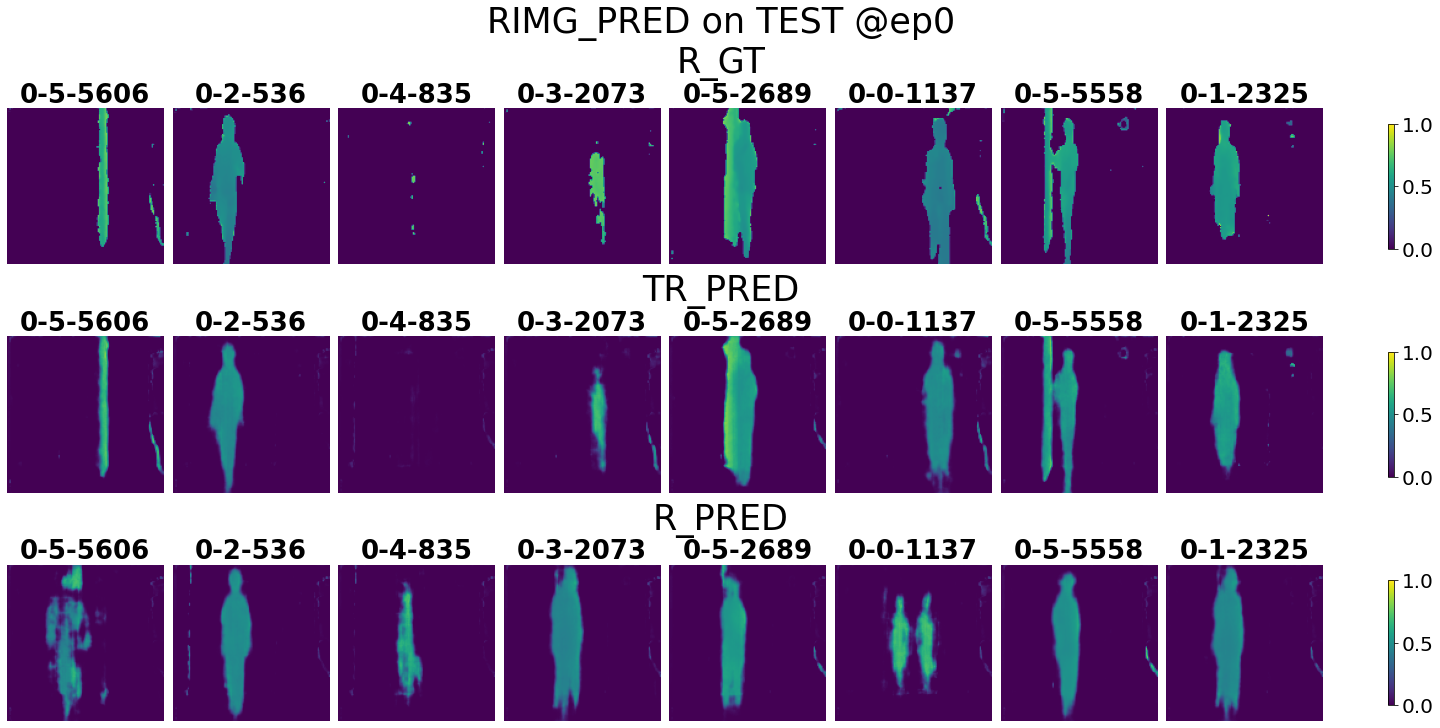

<Figure size 1440x720 with 0 Axes>

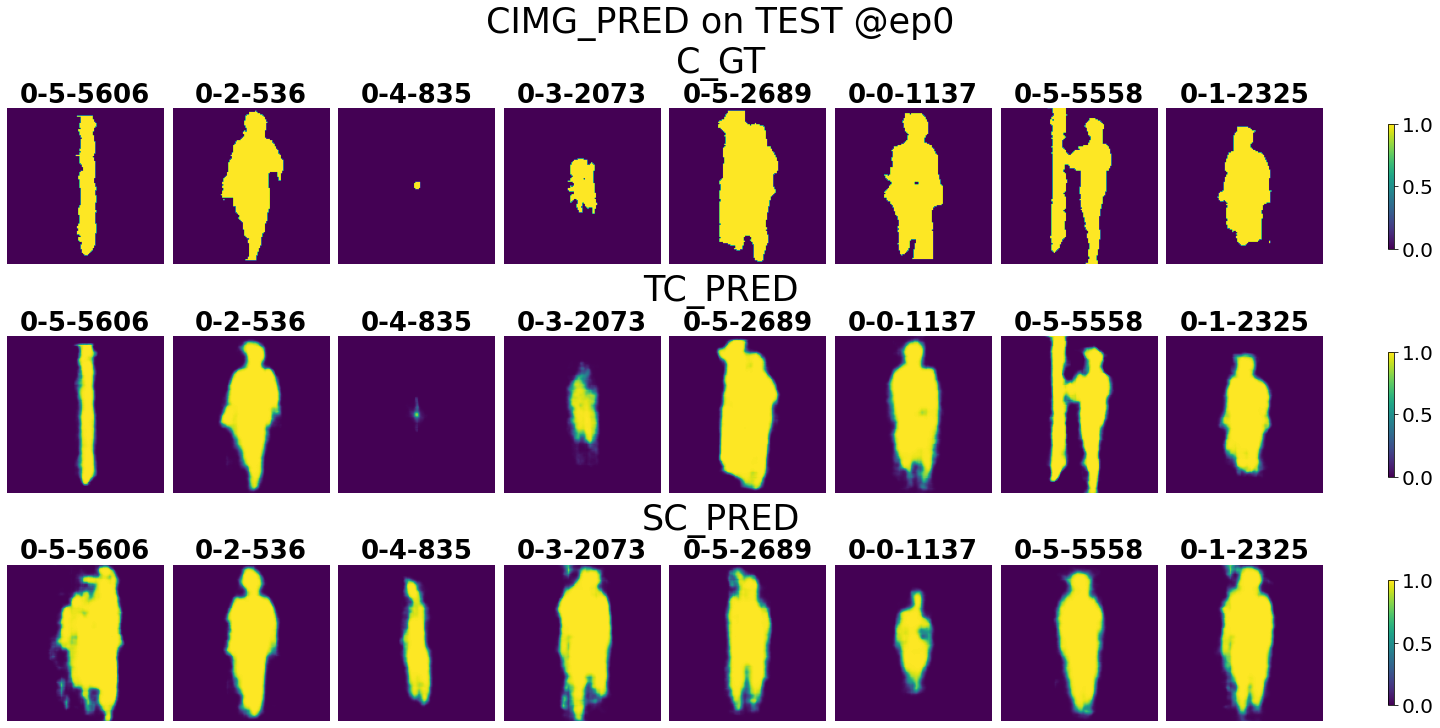

<Figure size 1440x720 with 0 Axes>

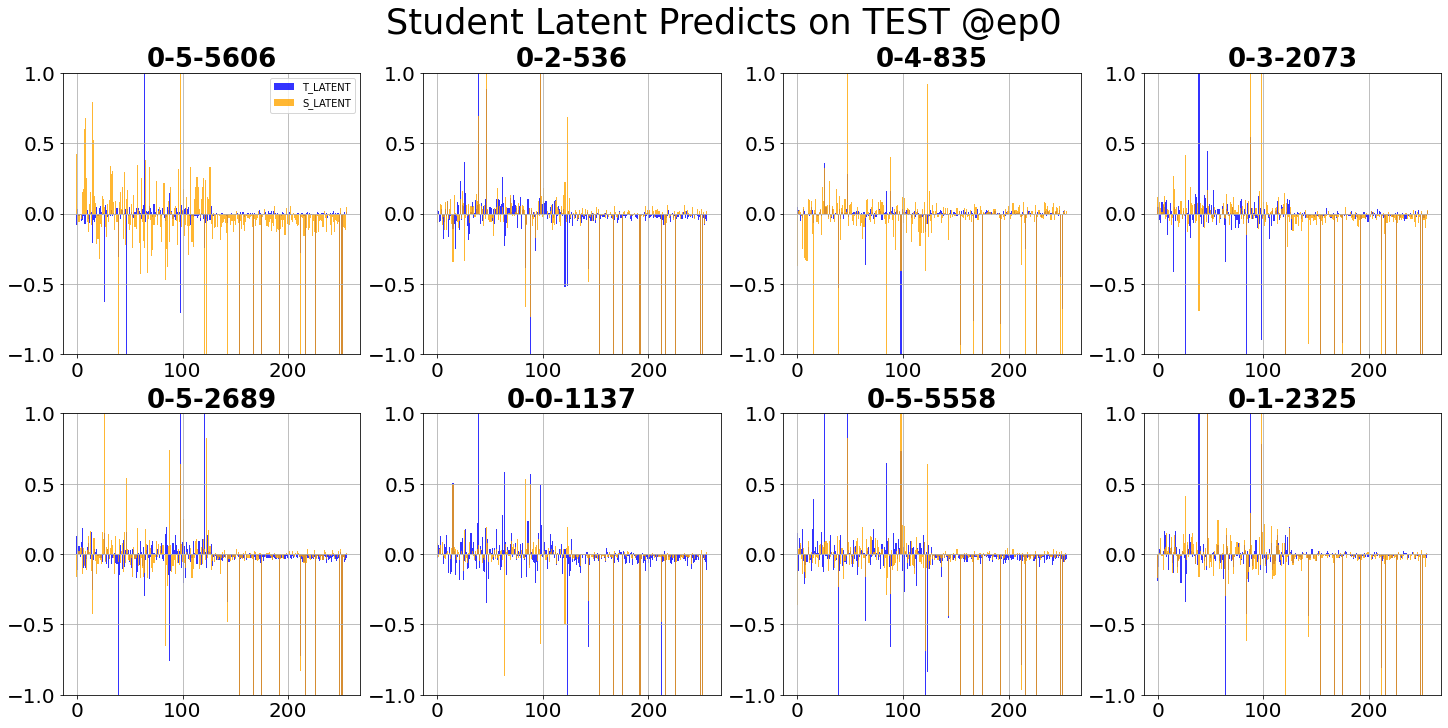

<Figure size 1440x720 with 0 Axes>

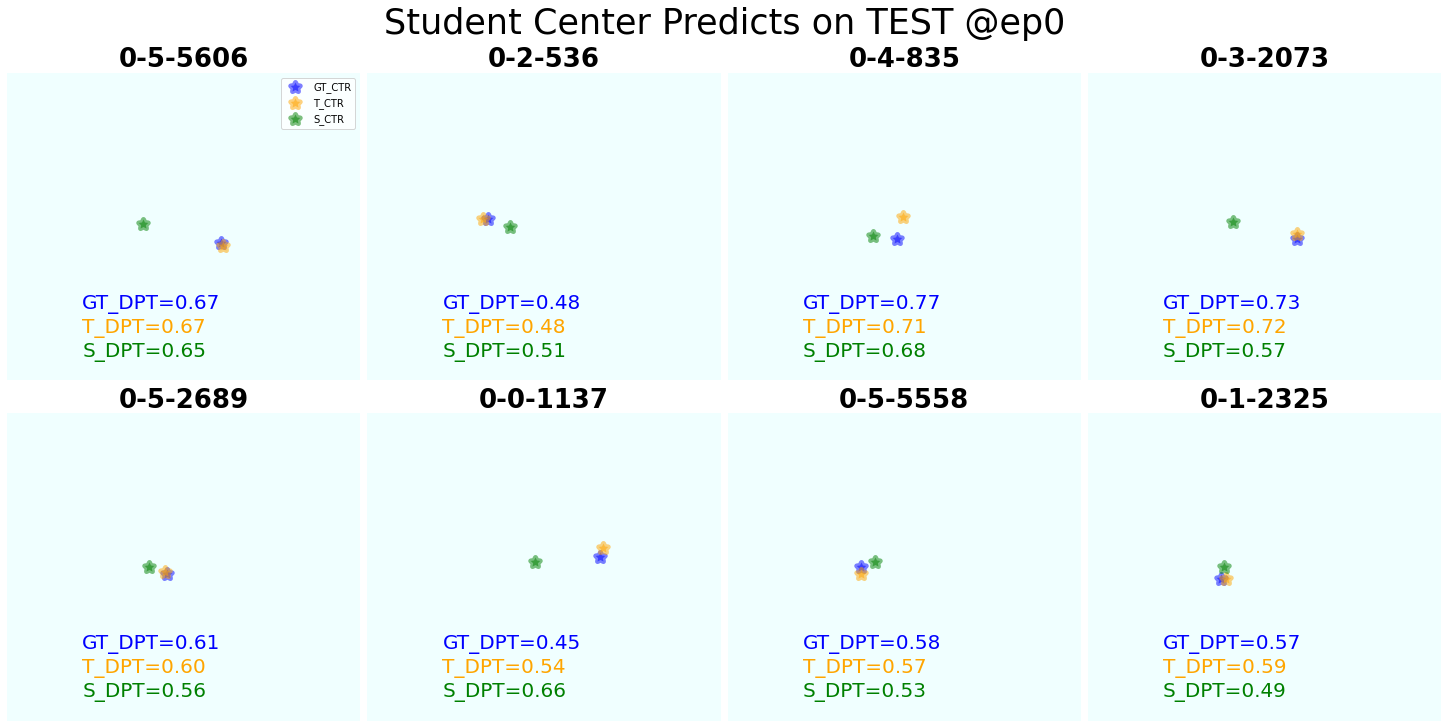

<Figure size 1440x720 with 0 Axes>

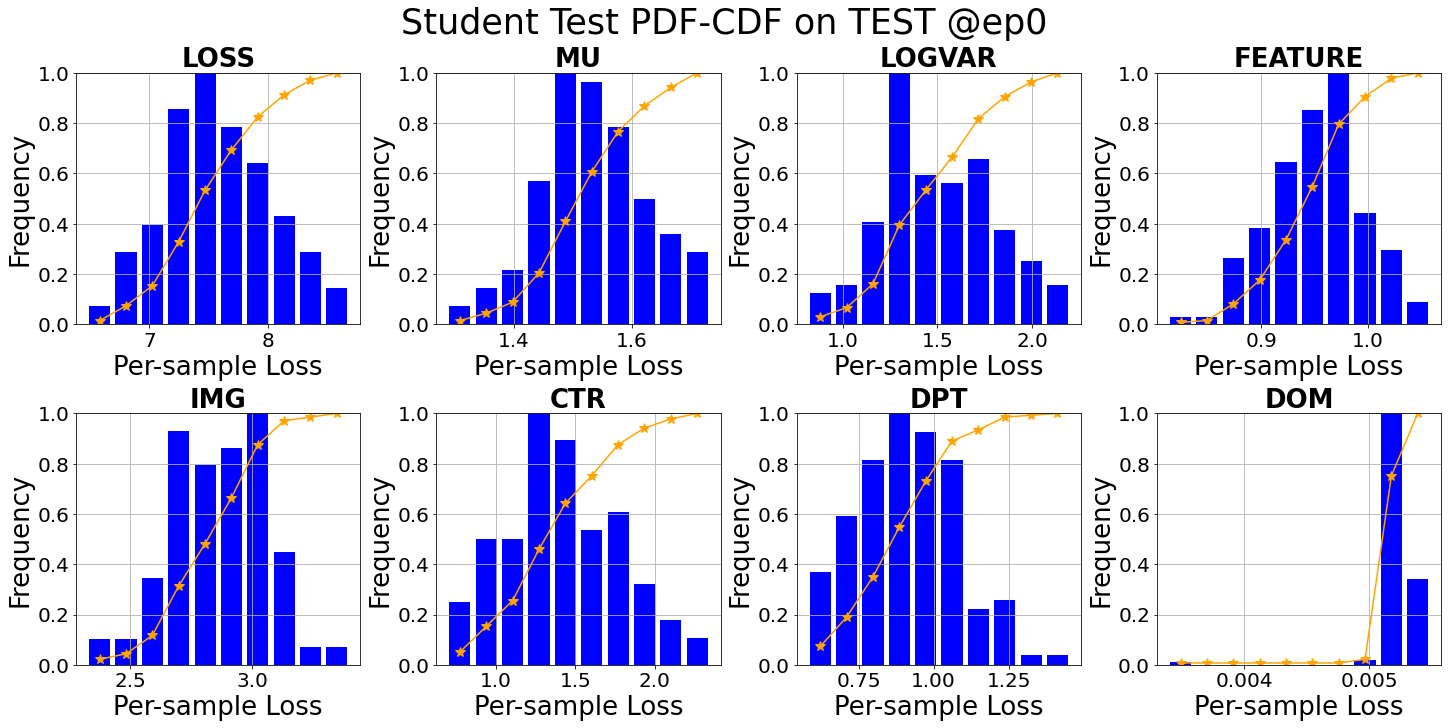

In [7]:
S_trainer.plot_test(autosave=True)

In [6]:
print(np.mean(S_trainer.losslog.loss['DOM'].log['test']))

0.5069665605095541


In [ ]:
S_trainer.dataloader['train'] = dann_train_loader
S_trainer.test(loader='train')
S_trainer.plot_test(autosave=False)